In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import yfinance as yf

from model.PDV import *
from model.HMM import *
from model.data import *

# Data

In [2]:
window = 1000
log_return = False
predict_t_plus_1 = False
regular_periods = True
multi_index_fit = True
n_regimes = 4
n_models = 8

filename = './data/sim_samples_v4.npy'

In [3]:
start_date = pd.to_datetime('1995-01-01')
end_date = pd.to_datetime('2023-08-31')
spx_data = pd.read_csv('./data/spx_data_nn.csv', index_col=0, parse_dates=[0])
vix_data = pd.read_csv('./data/vix_data_nn.csv', index_col=0, parse_dates=[0])
spx_data.index = pd.to_datetime(pd.to_datetime(spx_data.index, utc=True).date)
vix_data.index = pd.to_datetime(pd.to_datetime(vix_data.index, utc=True).date)
data = create_df_from_yf(spx_data, start_date, end_date, vix_data, predict_t_plus_1=predict_t_plus_1, log_return=log_return)
data

,r1,r2,vix
1995-01-04,0.003485,1.214534e-05,0.1353
1995-01-05,-0.000803,6.449659e-07,0.1350
1995-01-06,0.000739,5.454954e-07,0.1313
1995-01-09,0.000326,1.060104e-07,0.1333
1995-01-10,0.001845,3.402222e-06,0.1252
...,...,...,...
2023-08-24,-0.013458,1.811171e-04,0.1720
2023-08-25,0.006718,4.513107e-05,0.1568
2023-08-28,0.006265,3.924546e-05,0.1508
2023-08-29,0.014508,2.104910e-04,0.1445


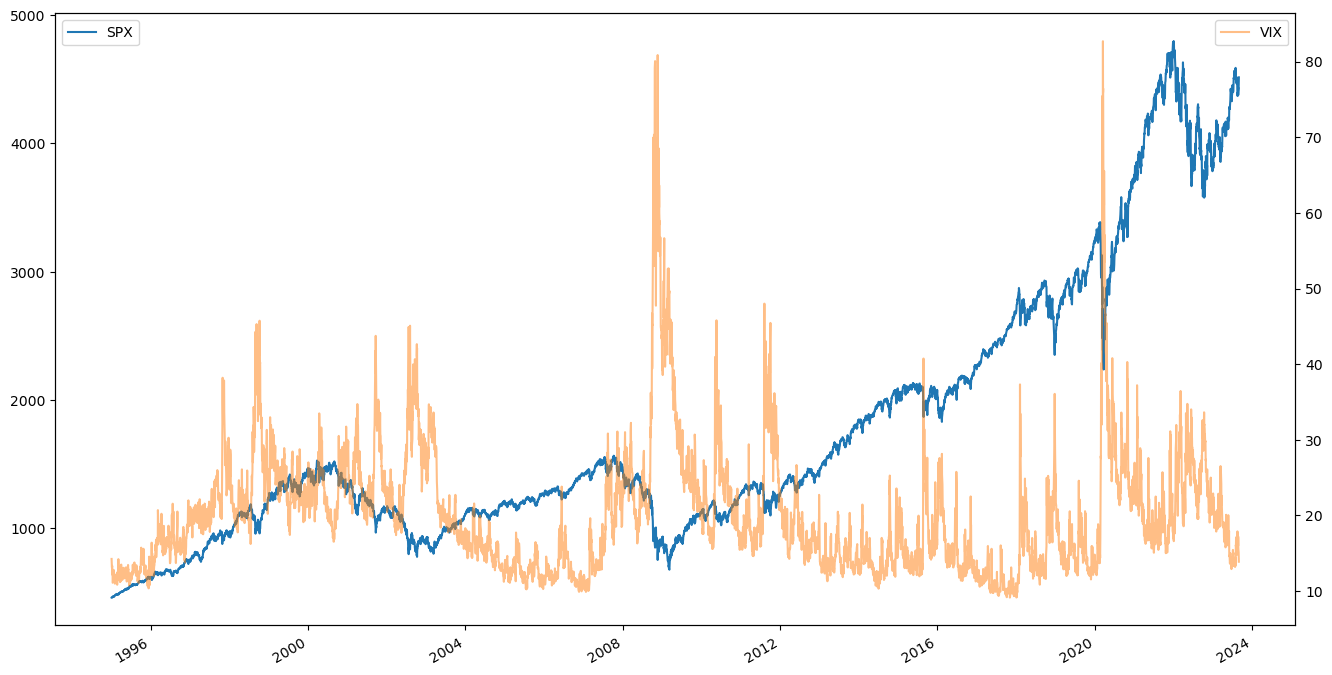

In [4]:
fig, ax = plt.subplots(figsize=(16,9))
spx_data[['Close']].plot(ax=ax, label='SPX')
ax2 = vix_data[['Close']].plot(ax=ax, label='VIX', secondary_y=True, alpha=0.5)
ax.legend(labels=['SPX'], loc='upper left')
ax2.legend(labels=['VIX'], loc='upper right')

In [5]:
# merged_df = pd.merge(spx_data['Close'], vix_data['Close'] / 100, left_index=True, right_index=True, )
# merged_df.rename(columns={'Close_x': 'SPX', 'Close_y': 'VIX'}, inplace=True)
# merged_df.to_csv('./data/spx_vix_df.csv')
# merged_df

# HMM for SPX

## Irregular time periods

In [6]:
if not regular_periods:
    for n in range(2, 2): # set end range to 2 to stop code running
        n_regimes = n
        spx_models = []
        print(f'Number of regimes: {n_regimes}')

        for i in range(1, 6):
            print(f'Run {i}')
            spx_model = IrregularPeriodsHMM(n_regimes, verbose=False)
            print(f'Initial parameters μ: {spx_model.μ}, σ: {spx_model.σ}, π: {np.exp(spx_model.π)}, A: \n{np.exp(spx_model.A)}')
            spx_model.EM_optimise(spx_data, tol=1e-7)
            spx_models.append(spx_model)
            spx_model.print_params()

            # save params to dataframe and csv
            spx_model.save_params_to_csv('./dataparams.csv', i)
            print('----------------------------------')

In [7]:
if not regular_periods:
    df = pd.read_csv('./data/params_v1.csv', index_col=0, converters={'μ': from_np_array, 'σ': from_np_array,
                                                            'π': from_np_array, 'A': from_np_array,
                                                            'π_alpha': from_np_array, 'A_alpha': from_np_array})
    df

In [8]:
if not regular_periods:
    n_regimes = 4
    model_num = 3
    spx_model = IrregularPeriodsHMM(n_regimes, verbose=False)
    spx_model.load_params_from_csv('./data/params_v1.csv', model_num)
    spx_model.predict(spx_data)

In [9]:
if not regular_periods:
    spx_model.plot_regimes_on_index()

## Regular time periods (using hmmlearn)

### Using SPX + UKX + DAX to train

In [10]:
# start_date = pd.to_datetime('1995-01-04')
# end_date = pd.to_datetime('2023-08-31')
# tickers = ['^GSPC', '^FTSE', '^GDAXI']
# # download data from yahoo finance
# hmm_data = yf.download(tickers, start=start_date, end=end_date, progress=False)
# hmm_data = hmm_data['Adj Close']
# hmm_data.dropna(inplace=True)
# hmm_data = hmm_data / hmm_data.iloc[0]
# hmm_data = hmm_data[tickers] # reorder columns so that first column is SPX

Model score: 70809.2900
Model score: 70826.3064
Model score: 70957.1579
Model score: 70787.9203
Model score: 70967.0867
Model score: 70842.6859
Model score: 70811.9656
Model score: 70831.2029
Best model: 4
Regime 0 count: 216
Regime 1 count: 3112
Regime 2 count: 1534
Regime 3 count: 2135
μ: [[-0.39302266 -0.59015448 -0.87879078]
 [ 0.34732085  0.21972566  0.39822435]
 [-0.07321337 -0.04798787 -0.10118582]
 [-0.06226081 -0.04655953 -0.05911172]]
σ: [[0.58687511 0.52031828 0.61672079]
 [0.09170917 0.09719053 0.12322287]
 [0.247214   0.2379446  0.31271094]
 [0.17131681 0.16455145 0.20870919]]
Drift: [[-0.56523386 -0.72552003 -1.06896305]
 [ 0.34311556  0.21500266  0.39063241]
 [-0.10377075 -0.07629668 -0.15007989]
 [-0.07693554 -0.06009812 -0.08089148]]
Transition:
[[8.82208889e-01 4.35901963e-06 1.17786752e-01 4.44083338e-17]
 [1.09059182e-33 9.10398941e-01 3.92613381e-07 8.96006661e-02]
 [1.91044036e-02 2.12565764e-04 9.53670160e-01 2.70128710e-02]
 [7.61234184e-11 1.26395503e-01 1.9620

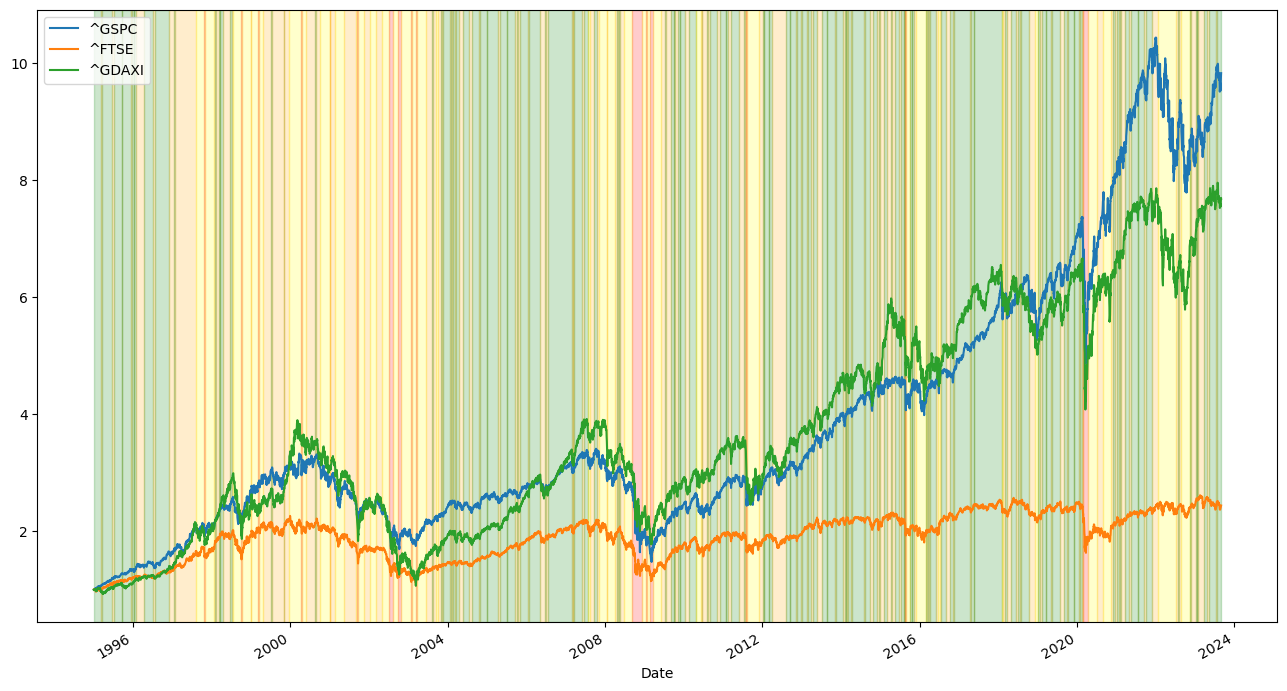

In [11]:
if regular_periods and multi_index_fit:
    hmm_data = pd.read_csv('./data/spx_ukx_dax_data.csv', index_col=0, parse_dates=[0])
    spx_model = RegularPeriodsHMM(n_regimes, n_models=8, verbose=False)
    spx_model.fit(hmm_data, hmm_data.columns)

### Using SPX alone

In [12]:
if regular_periods and not multi_index_fit:
    spx_model = RegularPeriodsHMM(n_regimes, n_models=8, verbose=False)
    spx_model.fit(spx_data)

### Simulate

In [14]:
sim_df = spx_model.simulate(spx_data.loc[spx_data.index[0], 'Close'], spx_data.index)

TypeError: no numeric data to plot

# PDV model for VIX

In [ ]:
pdv_initial_params = [0.054, -0.078, 0.82, 52.8, 3.79, 0.81, 17.3, 1.16, 0.43]
vix_model = PDV2Exp(pdv_initial_params)
lower_bound = [-np.inf, -np.inf, -np.inf, 0., 0., 0., 0., 0., 0.]
upper_bound = [np.inf, np.inf, np.inf, np.inf, np.inf, 1., np.inf, np.inf, 1.]
vix_model.optimise(data, window, lower_bound=lower_bound, upper_bound=upper_bound)
print(vix_model.params)
vix_model.evaluate(data, window)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9669e+00                                    4.13e+01    
       1              2         1.8019e+00      1.65e-01       5.16e+00       1.61e+01    
       2              3         1.6786e+00      1.23e-01       3.37e+00       9.05e-02    
       3              4         1.6782e+00      4.06e-04       1.56e+00       1.39e-01    
       4              5         1.6782e+00      2.71e-05       8.87e-01       8.03e-03    
       5              6         1.6782e+00      3.01e-06       3.60e-01       2.15e-03    
       6              7         1.6782e+00      6.84e-07       2.11e-01       5.66e-04    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 1.9669e+00, final cost 1.6782e+00, first-order optimality 5.66e-04.
[ 5.21701469e-02 -5.53679130e-02  8.56505202e-01  5.49078697e+01
  7.49764868e+00  7.55348518e-01  2.24407424e+01  1.7790522

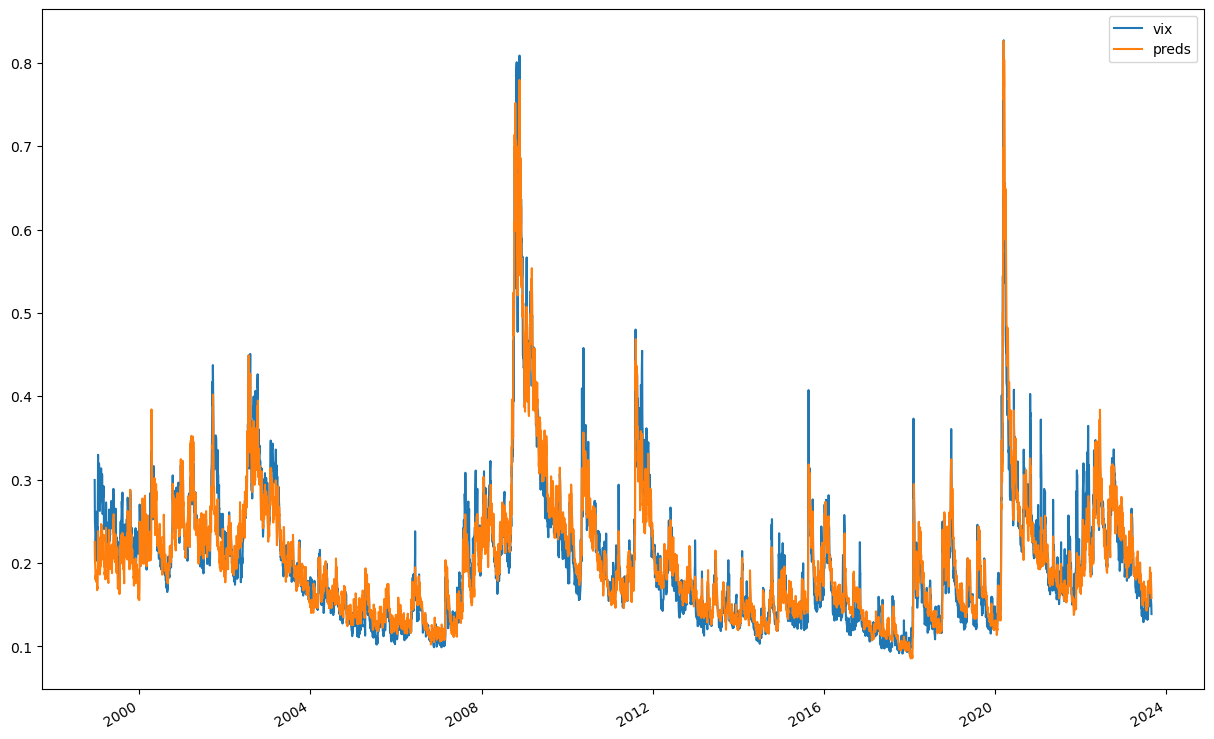

In [ ]:
vix_model.plot(data, window)

# Simulate SPX + VIX

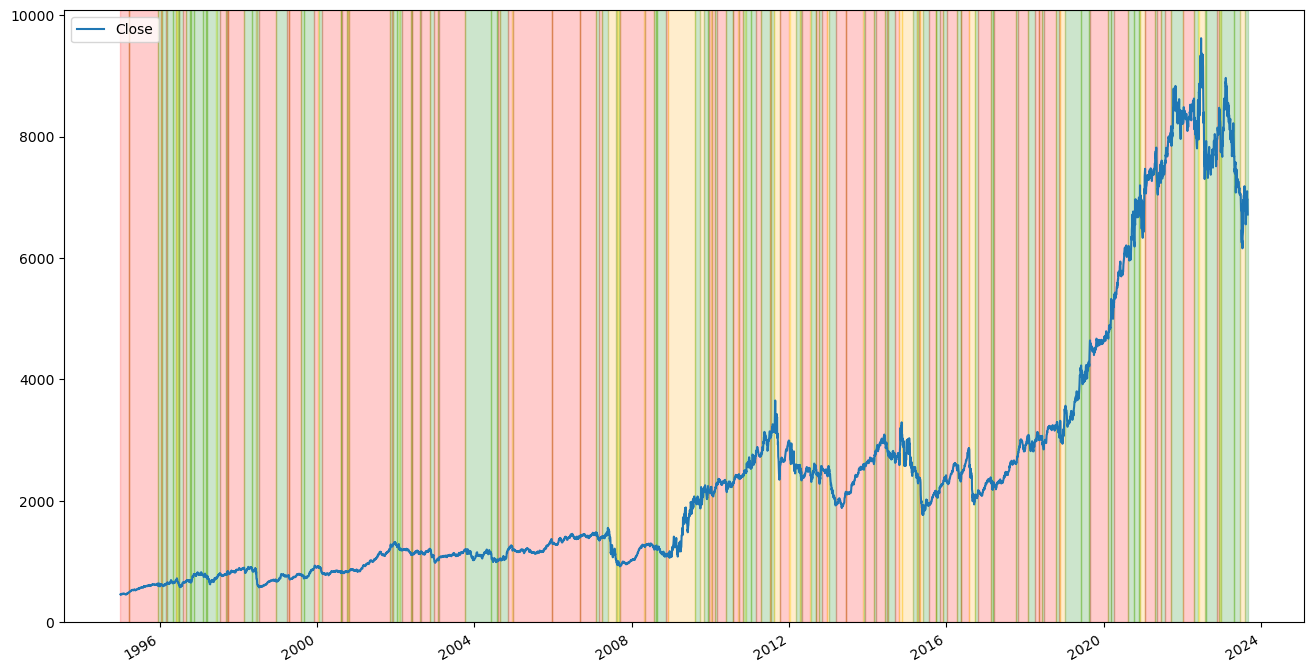

In [ ]:
# sim_df = spx_model.simulate(return_df=True)
sim_df = spx_model.simulate(spx_data.loc[spx_data.index[0], 'Close'], spx_data.index)

In [ ]:
r_df = create_df_from_yf(sim_df, sim_df.index[0], sim_df.index[-1]+pd.Timedelta(days=1), predict_t_plus_1=predict_t_plus_1, log_return=log_return)
r_df.drop_duplicates(inplace=True)
vix = vix_model.predict(r_df, window).numpy()
vix = list(np.zeros(window-1)) + list(vix)
sim_df['VIX'] = vix

In [ ]:
sim_df

,Close,VIX
1995-01-03,459.109985,0.000000
1995-01-04,456.561960,0.000000
1995-01-05,459.779060,0.000000
1995-01-06,458.266931,0.000000
1995-01-09,459.991812,0.000000
...,...,...
2023-08-24,7101.644126,0.267538
2023-08-25,6962.523094,0.292787
2023-08-28,6968.442721,0.282720
2023-08-29,6865.104020,0.298343


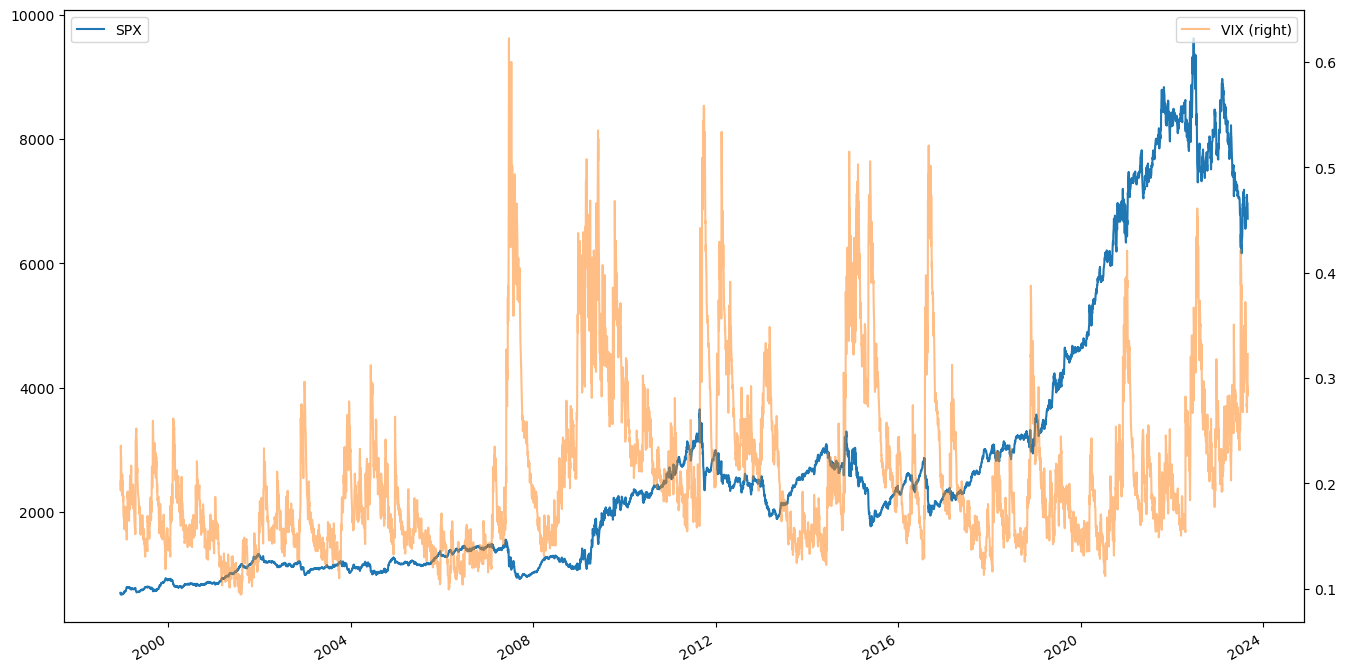

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
sim_df.columns = ['SPX', 'VIX']
sim_df.loc[sim_df.index[window-1:], 'SPX'].plot(ax=ax)
sim_df.loc[sim_df.index[window-1:], 'VIX'].plot(ax=ax, secondary_y=True, alpha=0.5)
ax.legend(loc='upper left')
plt.legend()

In [ ]:
# sim_df.to_csv('./data/sim_df_v1.csv')

# Batch simulation and save data

In [ ]:
n_samples = 100 # number of spx+vix samples to generate
spx_samples = spx_model.batch_simulate(n_samples, spx_data.loc[spx_data.index[0], 'Close'], spx_data.index) # simulate spx data
print(f'SPX sample shape: spx_samples.shape')
features = batch_create_df_from_yf(spx_samples, log_return=False) # create r1 and r2 features from spx data
print(f'Features shape: {features.shape}')
vix_samples = vix_model.batch_predict(features, spx_data.index[1:], window, return_numpy=True) # predict vix data from features
print(f'VIX sample shape: {vix_samples.shape}')
combined_samples = np.stack((spx_samples[:, -vix_samples.shape[-1]:], vix_samples), axis=-1)
print(f'Combined sample shape: {combined_samples.shape}')

SPX sample shape: spx_samples.shape
Features shape: (100, 7215, 2)
VIX sample shape: (100, 6216)
Combined sample shape: (100, 6216, 2)


In [ ]:
np.save(filename, combined_samples)

if regular_periods and multi_index_fit:
    mu = [x[0] for x in spx_model.mu]
    sigma = [x[0] for x in spx_model.sigma]
    pi = spx_model.pi
    transition = spx_model.transition
elif regular_periods and not multi_index_fit:
    mu = spx_model.mu
    sigma = spx_model.sigma
    pi = spx_model.pi
    transition = spx_model.transition
elif not regular_periods:
    mu = spx_model.μ
    sigma = spx_model.σ
    pi = spx_model.π
    transition = spx_model.A
else:
    raise Exception('No model specified')

df = {'filename': [filename],
      'n_regimes': [n_regimes],
      'n_models': [n_models],
      'log_return': [log_return],
      'predict_t_plus_1': [predict_t_plus_1],
      'regular_periods': [regular_periods],
      'multi_index_fit': [multi_index_fit],
      'mu': [mu],
      'sigma': [sigma],
      'pi': [pi],
      'transition': [transition]}

df = pd.DataFrame(df)
df.to_csv('./data/spx_vix_sim_params.csv', mode='a', header=(not os.path.exists('params.csv')))